In [25]:
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import optimize as sc
from numpy import linalg
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style("darkgrid")
plt.rc("figure", figsize=(10, 8))
plt.rc("savefig", dpi=90)

def download(tickers: list, years: int):
    """
    Downloads adjusted closing prices and the latest shares outstanding for a list of stock tickers.

    Parameters:
        tickers (list): List of stock tickers.
        years (int): Number of years of historical data to download.

    Returns:
        tuple:
            pd.DataFrame: DataFrame containing the adjusted closing prices of the tickers.
            pd.DataFrame: DataFrame containing the latest shares outstanding for each ticker.
    """
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days= 365 * years)
    mkt_data = yf.download(tickers, start= start_date, end= end_date, interval= '1d')['Adj Close']

    shares_outstanding = {}

    for ticker in tickers:
        end_date = dt.datetime.now()
        start_date = end_date - dt.timedelta(days= 365 * years)
        shares = yf.Ticker(ticker).get_shares_full(start= (dt.datetime.now() - dt.timedelta(days= 20)), end= None).iloc[-1]
        shares_outstanding[ticker] = shares
    shares_outstanding = pd.DataFrame([shares_outstanding])
    
    return shares_outstanding, mkt_data

In [26]:
def market_capitalization(shares_outstanding: pd.DataFrame, mkt_data: pd.DataFrame):
    """
    Calculates market capitalization weights for a list of stock tickers.

    Parameters:
        shares_outstanding (pd.DataFrame): DataFrame containing the latest shares outstanding for each ticker.
        mkt_data (pd.DataFrame): DataFrame containing adjusted closing prices for each ticker.

    Returns:
        pd.DataFrame: DataFrame containing the market capitalization weights for each ticker.
    """
    shares_outstanding = shares_outstanding.reindex(columns= mkt_data.columns[0:])
    shares_outstanding.to_dict()
    latest_price = mkt_data.iloc[-1].to_dict()
    shares_outstanding = {key: value[0] for key, value in shares_outstanding.items()}
    mkt_cap = {key: shares_outstanding[key] * latest_price[key] for key in shares_outstanding}
    total_mkt_cap = sum(mkt_cap.values())
    mkt_weights = {key: round(item / total_mkt_cap, 8) for key, item in mkt_cap.items()}
    mkt_weights = pd.DataFrame([mkt_weights])
    mkt_cap = pd.DataFrame([mkt_cap])

    return mkt_weights

In [27]:
def return_statistics(mkt_data: pd.DataFrame, mkt_weights: pd.DataFrame, annual_rfr: float):
    """
    Calculates various return statistics for a portfolio of assets.

    Parameters:
        mkt_data (pd.DataFrame): DataFrame containing adjusted closing prices for the assets.
        mkt_weights (pd.DataFrame): DataFrame containing portfolio weights for each asset.
        annual_rfr (float): Annualized risk-free rate.

    Returns:
        tuple:
            float: Portfolio Sharpe ratio (risk-adjusted return).
            pd.Series: Annualized standard deviations of asset returns.
            pd.Series: Annualized mean excess returns of the assets.
            pd.DataFrame: Covariance matrix of excess returns.
            pd.DataFrame: Correlation matrix of asset returns.
            np.ndarray: Portfolio weights as a NumPy array.
    """
    days = 365
    mkt_returns = np.log(mkt_data/mkt_data.shift(1)).dropna()
    daily_rfr = (1 + annual_rfr) ** (1 / days) - 1
    excess_mkt_returns = mkt_returns.subtract(daily_rfr, axis= 0)
    mkt_weights = mkt_weights.reindex(columns= excess_mkt_returns.columns[0:])
    
    weights_series = mkt_weights.loc[0]
    weights_array = weights_series.values

    cov_matrix = excess_mkt_returns.cov()
    corr_matrix = mkt_returns.corr()
    asset_stdev = mkt_returns.std() * np.sqrt(252)
    historical_mean_returns = excess_mkt_returns.mean() * 252

    global_pfolio_stdev = annualized_portfolio_stdev(weights_array, cov_matrix, 0)
    global_pfolio_returns = excess_mkt_returns.mean().multiply(weights_array).sum() * 252

    risk = global_pfolio_returns / global_pfolio_stdev

    return risk, asset_stdev, historical_mean_returns, cov_matrix, corr_matrix, weights_array

In [28]:
def implied_equilibrium_returns(risk_aversion: float, cov_matrix: pd.DataFrame, weights_array: np.ndarray):
    """
    Calculates the implied equilibrium returns for a portfolio.

    Parameters:
        risk_aversion (float): The risk aversion coefficient.
        cov_matrix (pd.DataFrame): Covariance matrix of asset returns.
        weights_array (np.ndarray): Array of portfolio weights.

    Returns:
        pd.Series: Implied equilibrium returns for each asset in the portfolio.
    """
    implied_equilibrium_returns = risk_aversion * cov_matrix.dot(weights_array).squeeze() * 252
    return implied_equilibrium_returns

In [29]:
def error_cov_matrix(cov_matrix: pd.DataFrame, tau: float, P: np.ndarray):
    """
    Calculates the error covariance matrix for a portfolio.

    Parameters:
        cov_matrix (pd.DataFrame): Covariance matrix of asset returns.
        tau (float): Scalar scaling factor.
        P (np.ndarray): Matrix that represents the relationship between assets and factors.

    Returns:
        np.ndarray: Error covariance matrix.
    """
    omega = np.diag(np.diag(P.dot(tau * cov_matrix).dot(P.T)))
    omega = omega * 252
    return omega

In [30]:
def black_litterman_returns(implied_equilibrium_rets: pd.Series, cov_matrix: pd.DataFrame, omega: np.ndarray, Q: np.ndarray, P: np.ndarray, tau: float):
    """
    Calculates the Black-Litterman returns vector.

    Parameters:
        implied_equilibrium_rets (pd.Series): Implied equilibrium returns.
        cov_matrix (pd.DataFrame): Covariance matrix of asset returns.
        omega (np.ndarray): Error covariance matrix.
        Q (np.ndarray): Vector of views on expected returns.
        P (np.ndarray): Matrix that represents the relationship between assets and views.
        tau (float): Scalar scaling factor.

    Returns:
        pd.Series: Black-Litterman returns vector.
    """
    sigma_scaled = cov_matrix * tau * 252
    BL_returns_vector = implied_equilibrium_rets + sigma_scaled.dot(P.T).dot(linalg.inv(P.dot(sigma_scaled).dot(P.T) + omega).dot(Q - P.dot(implied_equilibrium_rets)))
    return BL_returns_vector

In [31]:
def negative_sharpe(weights: np.ndarray, BL_returns: pd.Series, cov_matrix: pd.DataFrame, lambda_coeff):
    """
    Calculates the negative Sharpe ratio for a portfolio.

    Parameters:
        weights (np.ndarray): Array of portfolio weights.
        BL_returns (pd.Series): Black-Litterman returns vector.
        cov_matrix (pd.DataFrame): Covariance matrix of asset returns.
        lambda_coeff (float): Regularization coefficient for portfolio variance.

    Returns:
        float: Negative Sharpe ratio of the portfolio.
    """
    portfolio_mean_return = annualized_portfolio_return(weights, BL_returns)
    portfolio_stdev = annualized_portfolio_stdev(weights, cov_matrix, lambda_coeff)
    return -portfolio_mean_return/portfolio_stdev

def annualized_portfolio_return(weights: np.ndarray, BL_returns: pd.Series):
    """
    Calculates the annualized return of the portfolio.

    Parameters:
        weights (np.ndarray): Array of portfolio weights.
        BL_returns (pd.Series): Black-Litterman returns vector.

    Returns:
        float: Annualized return of the portfolio.
    """
    portfolio_mean_return = np.sum(BL_returns * weights)
    return portfolio_mean_return

def annualized_portfolio_stdev(weights: np.ndarray, cov_matrix: pd.DataFrame, lambda_coeff: float):
    """
    Calculates the annualized standard deviation (volatility) of the portfolio.

    Parameters:
        weights (np.ndarray): Array of portfolio weights.
        cov_matrix (pd.DataFrame): Covariance matrix of asset returns.
        lambda_coeff (float): Regularization coefficient for portfolio variance.

    Returns:
        float: Annualized standard deviation of the portfolio.
    """
    portfolio_stdev = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(252)
    l2_penalty = lambda_coeff * np.sum(weights**2)
    return portfolio_stdev + l2_penalty

def max_sharpe(BL_returns: pd.Series, cov_matrix: pd.DataFrame, bound: tuple, method: str, lambda_coeff: float):
    """
    Optimizes the portfolio to maximize the Sharpe ratio.

    Parameters:
        BL_returns (pd.Series): Black-Litterman returns vector.
        cov_matrix (pd.DataFrame): Covariance matrix of asset returns.
        bound (tuple): Bound for portfolio weights.
        method (str): Optimization method (e.g., 'SLSQP').
        lambda_coeff (float): Regularization coefficient for portfolio variance.

    Returns:
        tuple:
            result: Optimization result.
            max_sharpe_returns (float): Maximum Sharpe ratio portfolio return.
            max_sharpe_stdev (float): Maximum Sharpe ratio portfolio standard deviation.
            max_sharpe_allocation (pd.DataFrame): Portfolio allocation for maximum Sharpe ratio.
    """
    n_assets = len(BL_returns)
    args = (BL_returns, cov_matrix, lambda_coeff)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple(bound for asset in range(n_assets))
    result = sc.minimize(negative_sharpe, n_assets*[1./n_assets], args=args, method=method, bounds=bounds, constraints=constraints)

    max_sharpe_returns = annualized_portfolio_return(result['x'], BL_returns)
    max_sharpe_stdev = annualized_portfolio_stdev(result['x'], cov_matrix, lambda_coeff)
    max_sharpe_allocation = pd.DataFrame(result['x'], index= BL_returns.index, columns= ['ALLOCATION'])
    max_sharpe_allocation.ALLOCATION = [round(i*100, 0) for i in max_sharpe_allocation.ALLOCATION]

    return result, max_sharpe_returns, max_sharpe_stdev, max_sharpe_allocation

In [32]:
def minimum_variance(BL_returns: pd.Series, cov_matrix: pd.DataFrame, bound: tuple, method: str, lambda_coeff: float):
    """
    Optimizes the portfolio to minimize variance (risk).

    Parameters:
        BL_returns (pd.Series): Black-Litterman returns vector.
        cov_matrix (pd.DataFrame): Covariance matrix of asset returns.
        bound (tuple): Bound for portfolio weights.
        method (str): Optimization method (e.g., 'SLSQP').
        lambda_coeff (float): Regularization coefficient for portfolio variance.

    Returns:
        tuple:
            result: Optimization result.
            minimum_variance_returns (float): Minimum variance portfolio return.
            minimum_variance_stdev (float): Minimum variance portfolio standard deviation.
            minimum_variance_allocation (pd.DataFrame): Portfolio allocation for minimum variance.
            minimum_variance_sharpe (float): Sharpe ratio for the minimum variance portfolio.
    """
    n_assets = len(BL_returns)
    args = (cov_matrix, lambda_coeff)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple(bound for asset in range(n_assets))
    result = sc.minimize(annualized_portfolio_stdev, n_assets*[1./n_assets], args=args, method=method, bounds=bounds, constraints=constraints)

    minimum_variance_returns = annualized_portfolio_return(result['x'], BL_returns)
    minimum_variance_stdev = annualized_portfolio_stdev(result['x'], cov_matrix, lambda_coeff)
    minimum_variance_allocation = pd.DataFrame(result['x'], index= BL_returns.index, columns= ['ALLOCATION'])
    minimum_variance_allocation.ALLOCATION = [round(i*100, 0) for i in minimum_variance_allocation.ALLOCATION]
    minimum_variance_sharpe = minimum_variance_returns / minimum_variance_stdev

    return result, minimum_variance_returns, minimum_variance_stdev, minimum_variance_allocation, minimum_variance_sharpe


In [33]:
def efficient_frontier(BL_returns: pd.Series, cov_matrix: np.ndarray, bound: tuple, mv: float, ms: float, method: str, lambda_coeff: float):
    """
    Calculates the efficient frontier for a portfolio.

    Parameters:
        BL_returns (pd.Series): Black-Litterman returns vector.
        cov_matrix (np.ndarray): Covariance matrix of asset returns.
        bound (tuple): Bound for portfolio weights.
        mv (float): Minimum variance portfolio return.
        ms (float): Maximum Sharpe ratio portfolio return.
        method (str): Optimization method (e.g., 'SLSQP').
        lambda_coeff (float): Regularization coefficient for portfolio variance.

    Returns:
        tuple:
            efficient (list): List of portfolio standard deviations along the efficient frontier.
            return_target (np.ndarray): Array of target returns corresponding to the efficient frontier.
            sharpe (list): List of Sharpe ratios for portfolios along the efficient frontier.
            results (list): List of optimization results for each point on the efficient frontier.
    """
    return_target = np.linspace(mv, ms, 100)
    efficient = []
    sharpe = []
    results= []
    
    for target in return_target:
        n_assets = len(BL_returns)
        args = (cov_matrix, lambda_coeff)
        constraints = ({'type':'eq', 'fun': lambda x: annualized_portfolio_return(x, BL_returns) - target}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple(bound for asset in range(n_assets))
        result = sc.minimize(annualized_portfolio_stdev, n_assets*[1./n_assets], args=args, method=method, bounds=bounds, constraints= constraints)
        efficient.append(result.fun)
        sharpe.append((target)/result.fun)
        results.append(result)
        
    return efficient, return_target, sharpe, results

In [34]:
def summary(implied_equilibrium_rets: pd.Series, BL_returns_vector: pd.Series, result_max_sharpe: sc.OptimizeResult, result_minimum_variance: sc.OptimizeResult,
            result_efficient_frontier: list, minimum_variance_sharpe: float, minimum_variance_returns: float, minimum_variance_stdev: float, max_sharpe_returns: float,
            max_sharpe_stdev: float, method: str, max_sharpe_allocation: pd.DataFrame, minimum_variance_allocation: pd.DataFrame, stock_data: pd.DataFrame, constaints: tuple,
            lambda_coeff: float, amount: int, risk_aversion: float, annual_rfr: float, tau: float, asset_stdev: pd.Series, historical_mean_returns: pd.Series):
    """
    Generates a detailed summary report for the Black-Litterman model, including optimization results, portfolio allocations, returns, and statistics.

    Parameters:
        implied_equilibrium_rets (pd.Series): Implied equilibrium returns.
        BL_returns_vector (pd.Series): Black-Litterman returns vector.
        result_max_sharpe (sc.OptimizeResult): Result of the maximum Sharpe ratio optimization.
        result_minimum_variance (sc.OptimizeResult): Result of the minimum variance optimization.
        result_efficient_frontier (list): List of optimization results along the efficient frontier.
        minimum_variance_sharpe (float): Sharpe ratio for the minimum variance portfolio.
        minimum_variance_returns (float): Return for the minimum variance portfolio.
        minimum_variance_stdev (float): Standard deviation for the minimum variance portfolio.
        max_sharpe_returns (float): Return for the maximum Sharpe ratio portfolio.
        max_sharpe_stdev (float): Standard deviation for the maximum Sharpe ratio portfolio.
        method (str): Optimization method used (e.g., 'SLSQP').
        max_sharpe_allocation (pd.DataFrame): Allocation of assets in the maximum Sharpe ratio portfolio.
        minimum_variance_allocation (pd.DataFrame): Allocation of assets in the minimum variance portfolio.
        stock_data (pd.DataFrame): Historical stock data for the assets.
        constaints (tuple): Weight constraints for the portfolio optimization.
        lambda_coeff (float): Regularization coefficient for portfolio variance.
        amount (int): Amount of capital allocated to the portfolio.
        risk_aversion (float): Risk aversion coefficient.
        annual_rfr (float): Annual risk-free rate.
        tau (float): Black-Litterman tau.
        asset_stdev (pd.Series): Standard deviation of each asset's returns.
        historical_mean_returns (pd.Series): Historical mean returns of the assets.

    Returns:
        None: Prints a detailed summary report.
    """
    ef_vals = []
    ef_nits = 0
    for result in result_efficient_frontier:
        ef_vals.append(result.success)
        ef_nits += result.nit
    status_efficient_frontier = all(i for i in ef_vals)

    if status_efficient_frontier:
        status_efficient_frontier = 'Success'
    else:
        status_efficient_frontier = 'Failure'

    if result_max_sharpe.success:
        status_max_sharpe = 'Success'
    else:
        status_max_sharpe = 'Failure'

    if result_minimum_variance.success:
        status_minimum_variance = 'Success'
    else:
        status_minimum_variance = 'Failure'

    def portfolio_discrete_allocation(allocations, data, amount):
        currency_amount = (allocations / 100 * amount)
        stock_price = data.iloc[-1]
        discrete_allocation = pd.concat([currency_amount, stock_price], axis= 1)
        discrete_allocation = round(discrete_allocation.iloc[:, 0] / discrete_allocation.iloc[:, 1], 0)
        allocations = pd.concat([currency_amount, discrete_allocation], axis= 1)
        
        return allocations

    returns_table = pd.concat([implied_equilibrium_rets, BL_returns_vector], axis=1) * 100
    returns_table.columns = ['Implied Returns', 'BL Returns']
    returns_table['Change (%)'] = returns_table['BL Returns'] - returns_table['Implied Returns']
    returns_table['Historical Returns'] = historical_mean_returns * 100
    returns_table['Asset Stdev'] = asset_stdev * 100
    returns_table['Historical Sharpe'] = historical_mean_returns / asset_stdev
    returns_table['BL Sharpe'] = BL_returns_vector / asset_stdev

    allocations_MaxSR = pd.concat([max_sharpe_allocation, portfolio_discrete_allocation(max_sharpe_allocation, stock_data, amount)], axis=1)
    allocations_MinVol = pd.concat([minimum_variance_allocation, portfolio_discrete_allocation(minimum_variance_allocation, stock_data, amount)], axis=1)
    allocations_MaxSR.columns = ['ALLOCATION (%)', 'AMOUNT (€)', 'DISCRETE ALLOCATION (pcs.)']
    allocations_MinVol.columns = ['ALLOCATION (%)', 'AMOUNT (€)', 'DISCRETE ALLOCATION (pcs.)']

    print('\n')
    print('Black-Litterman Model Results'.center(79))
    print(79* "=")
    print('Max Sharpe optimization status:'.ljust(69) + str(status_max_sharpe))
    print('Min Volatility optimization status:'.ljust(69) + str(status_minimum_variance))
    print('Efficient Frontier optimization status:'.ljust(69) + str(status_efficient_frontier))
    print('')
    print('Optimization method:'.ljust(69) + 'Numerical')
    print('Optimization algorithm:'.ljust(69) + method)
    print('L2 Regularisation lambda coefficient:'.ljust(69) + str(lambda_coeff))
    print('Weight constraints:'.ljust(69) + str(constaints))
    print('')
    print('Iterations (MaxSR):'.ljust(69) + str(result_max_sharpe.nit))
    print('Iterations (MinVol):'.ljust(69) + str(result_minimum_variance.nit))
    print('Iterations (EF):'.ljust(69) + str(ef_nits)) 
    print('')
    print('Annual risk-free rate:'.ljust(69) + str(annual_rfr * 100) + ' %')
    print('Risk aversion coefficient:'.ljust(69) + str(round(risk_aversion, 2)))
    print('Black-Litterman Tau:'.ljust(69) + str(tau))
    print('')
    print('Capital allocated:'.ljust(69) + str(amount) + '€')
    print('Date:'.ljust(69) + str(dt.datetime.now().date()))
    print('Time:'.ljust(69) + str(dt.datetime.now().time().replace(microsecond=0)))
    print('')
    print(79*'=')
    print('Returns Table'.center(79))
    print(79*'-')
    print(returns_table)
    print('')
    print(79*'=')
    print('BL Max Sharpe Allocations'.center(79))
    print(79*'-')
    print(allocations_MaxSR)
    print('')
    print('Annualized portfolio return:'.ljust(69) + str(round(max_sharpe_returns, 2)))
    print('Annualized portfolio standard deviation:'.ljust(69) + str(round(max_sharpe_stdev, 2)))
    print('Annualized portfolio Sharpe ratio:'.ljust(69) + str(round(-result_max_sharpe.fun, 2)))
    print('')
    print(79*'=')
    print('BL Min Volatility Allocations'.center(79))
    print(79*'-')
    print(allocations_MinVol)
    print('')
    print('Annualized portfolio return:'.ljust(69) + str(round(minimum_variance_returns, 2)))
    print('Annualized portfolio standard deviation:'.ljust(69) + str(round(minimum_variance_stdev, 2)))
    print('Annualized portfolio Sharpe ratio:'.ljust(69) + str(round(minimum_variance_sharpe, 2)))
    print('')
    print(79*'=')
    print('Message (MaxSR): ' + result_max_sharpe.message)
    print('Message (MinVol): ' + result_minimum_variance.message)
    print(79*'-')

In [35]:
def plot(x: list, y: np.ndarray, z: list, minimum_variance_returns: float, minimum_variance_stdev: float, 
         max_sharpe_returns: float, max_sharpe_stdev: float, result_max_sharpe: sc.OptimizeResult, corr_matrix: pd.DataFrame):
     """
     Generates a plot of the efficient frontier along with a correlation heatmap and markers for the maximum Sharpe ratio and minimum volatility portfolios.

     Parameters:
          x (list): List of portfolio standard deviations (volatilities) along the efficient frontier.
          y (np.ndarray): Array of portfolio returns along the efficient frontier.
          z (list): List of Sharpe ratios corresponding to the points on the efficient frontier.
          minimum_variance_returns (float): Return of the minimum variance portfolio.
          minimum_variance_stdev (float): Standard deviation of the minimum variance portfolio.
          max_sharpe_returns (float): Return of the maximum Sharpe ratio portfolio.
          max_sharpe_stdev (float): Standard deviation of the maximum Sharpe ratio portfolio.
          result_max_sharpe (sc.OptimizeResult): Result of the maximum Sharpe ratio optimization.
          corr_matrix (pd.DataFrame): Correlation matrix of the assets.

     Returns:
          fig (matplotlib.figure.Figure): A figure object containing the generated plots (efficient frontier and correlation heatmap).
     """
     scatter = plt.scatter(x, y, c= z, marker= 'o', cmap='viridis', label='Efficient Frontier')

     max_sharpe_ratio = round(-result_max_sharpe.fun, 2)
     min_vol_sharpe_ratio = round(minimum_variance_returns/minimum_variance_stdev, 2)

     plt.scatter(max_sharpe_stdev, max_sharpe_returns, marker='o', color='r', s=200, label=f'Maximum Sharpe ratio: {max_sharpe_ratio}')
     plt.scatter(minimum_variance_stdev, minimum_variance_returns, marker='o', color='g', s=200, label=f'Minimum volatility Sharpe: {min_vol_sharpe_ratio}')

     plt.xlabel('Volatility')
     plt.ylabel('Annual returns')
     plt.legend(labelspacing=0.8, loc= 'lower right')
     plt.title('Efficient Frontier', fontdict={'fontsize':18}, pad=12)
     plt.colorbar(scatter, label='Sharpe ratio')

     fig = plt.figure(figsize=(10, 8))
     mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
     ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='rocket_r', square=True, vmin=-1, vmax=1, mask= mask, cbar= True)
     ax.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
     ax.xaxis.tick_bottom()
     ax.yaxis.tick_left()
     return fig

[*********************100%%**********************]  13 of 13 completed




                         Black-Litterman Model Results                         
Max Sharpe optimization status:                                      Success
Min Volatility optimization status:                                  Success
Efficient Frontier optimization status:                              Success

Optimization method:                                                 Numerical
Optimization algorithm:                                              SLSQP
L2 Regularisation lambda coefficient:                                0.0
Weight constraints:                                                  (0, 1)

Iterations (MaxSR):                                                  9
Iterations (MinVol):                                                 9
Iterations (EF):                                                     761

Annual risk-free rate:                                               3.0 %
Risk aversion coefficient:                                           0.5
Black-Litterman Ta

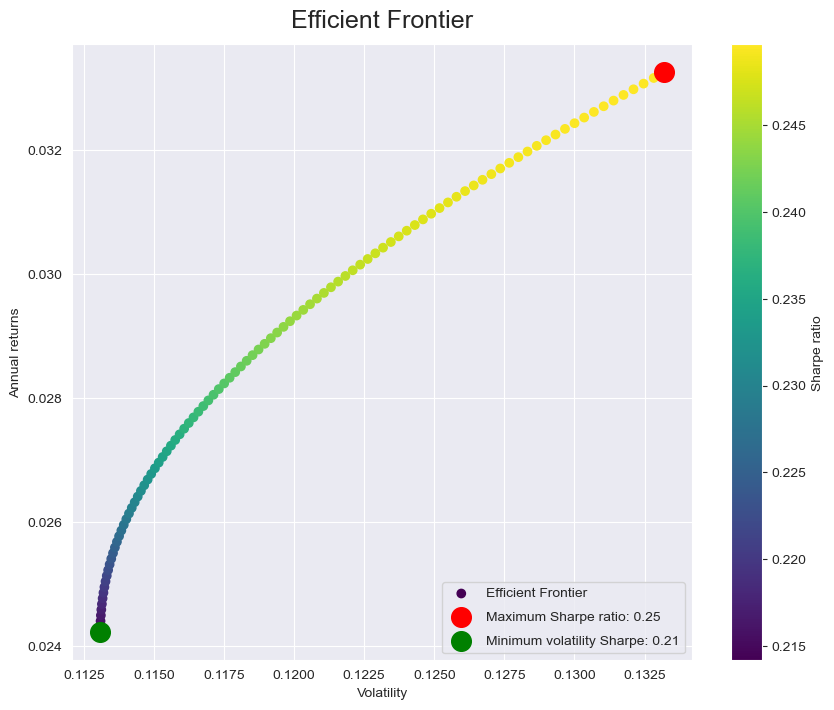

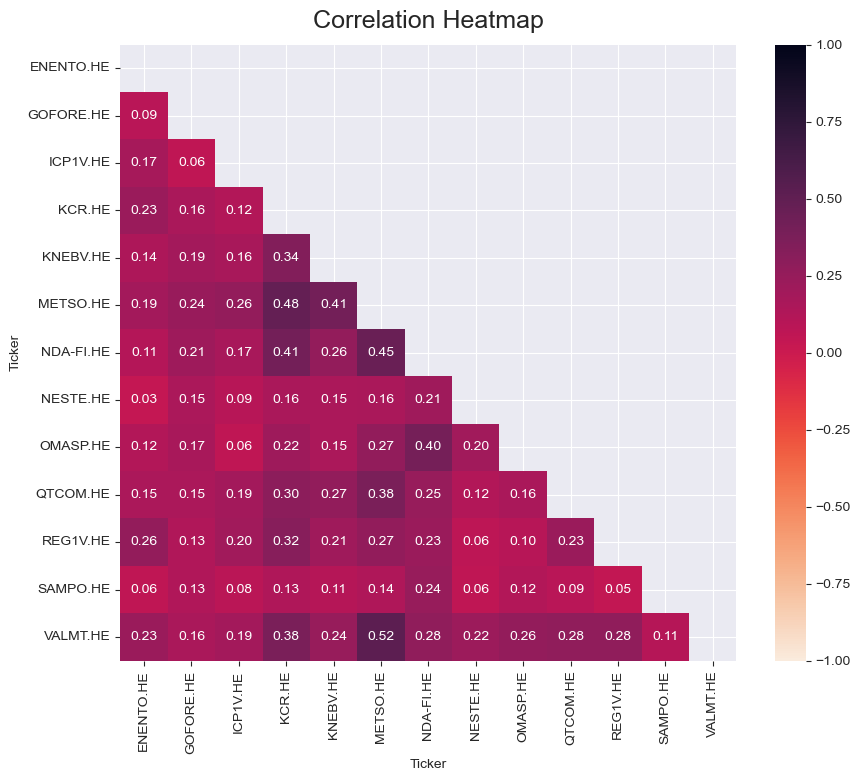

In [36]:
def main(tickers: list, years: int):
    """
    This function performs portfolio optimization using the Black-Litterman model. It downloads 
    market data for the given tickers, calculates necessary financial statistics, applies the 
    Black-Litterman model to adjust expected returns, and performs optimization for maximum 
    Sharpe ratio and minimum volatility. The function also generates the efficient frontier, 
    portfolio allocations, and plots the results, including a correlation heatmap.

    Parameters:
        tickers (list): A list of stock tickers (strings) for which to download market data.
        years (int): The number of years of historical data to download for each ticker.

    Returns:
        plotting (matplotlib.figure.Figure): A figure containing the plot of the efficient frontier and the correlation heatmap.
    
    Notes:
    ------
    The function depends on several other functions defined elsewhere (e.g., download, 
    market_capitalization, return_statistics, implied_equilibrium_returns, black_litterman_returns, 
    etc.) to perform necessary calculations for portfolio optimization. It assumes that the tickers 
    provided are valid and that market data can be retrieved successfully for the specified time period.
    """

    #Constants
    ANNUAL_RFR = 0.03
    RISK_AVERSION = 2.25
    TAU = 5

    Q = np.array([0.05, 0.02, 0.01])
    P = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0.98, 0, -0.02, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

    CONSTRAINTS = (0,1)
    METHOD = 'SLSQP'
    LAMBDA_COEFF = 0.0
    AMOUNT = 10000

    #Function calls
    shares_outstanding, mkt_data = download(tickers, years)
    mkt_weights = market_capitalization(shares_outstanding, mkt_data)
    risk, asset_stdev, historical_mean_returns, cov_matrix, corr_matrix, weights_array = return_statistics(mkt_data, mkt_weights, ANNUAL_RFR)
    implied_equilibrium_rets = implied_equilibrium_returns(RISK_AVERSION, cov_matrix, weights_array)
    omega = error_cov_matrix(cov_matrix, TAU, P)
    BL_returns_vector = black_litterman_returns(implied_equilibrium_rets, cov_matrix, omega, Q, P, TAU)

    result_max_sharpe, max_sharpe_returns, max_sharpe_stdev, max_sharpe_allocation = max_sharpe(BL_returns_vector, cov_matrix, CONSTRAINTS, METHOD, LAMBDA_COEFF)
    result_minimum_variance, minimum_variance_returns, minimum_variance_stdev, minimum_variance_allocation, minimum_variance_sharpe = minimum_variance(BL_returns_vector, cov_matrix, CONSTRAINTS, METHOD, LAMBDA_COEFF)
    efficient, return_target, sharpe, result_efficient_frontier = efficient_frontier(BL_returns_vector, cov_matrix, CONSTRAINTS, minimum_variance_returns, max_sharpe_returns, METHOD, LAMBDA_COEFF)
    plotting = plot(efficient, return_target, sharpe, minimum_variance_returns, minimum_variance_stdev, max_sharpe_returns, max_sharpe_stdev, result_max_sharpe, corr_matrix)
    summary(implied_equilibrium_rets, BL_returns_vector, result_max_sharpe, result_minimum_variance, result_efficient_frontier, minimum_variance_sharpe, minimum_variance_returns, minimum_variance_stdev, max_sharpe_returns, max_sharpe_stdev, METHOD, max_sharpe_allocation, minimum_variance_allocation, mkt_data, CONSTRAINTS, LAMBDA_COEFF, AMOUNT, risk, ANNUAL_RFR, TAU, asset_stdev, historical_mean_returns)

    return plotting



plotting = main(["SAMPO.HE", "ENENTO.HE", "KCR.HE", "GOFORE.HE", "NESTE.HE", "OMASP.HE", "QTCOM.HE", "REG1V.HE", "VALMT.HE", "ICP1V.HE", "METSO.HE", "KNEBV.HE", "NDA-FI.HE"], 1)
